In [32]:
import os
from nilearn import datasets, plotting, image
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
import numpy as np
import pandas as pd

In [33]:
data_path = '/Volumes/GPulickal/processed'
file_list = os.listdir(data_path)

In [34]:
preprocessed_list = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if 'desc-preproc_bold.nii.gz' in file:
            preprocessed_list.append(os.path.join(root, file))
preprocessed_list.sort()

In [36]:
##Generate the atlas used to map the brain
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

##Make dictionary of the positions of the brain segments and the positions in MNI space
#Find the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
seg_pos = {}
for i in range(len(atlas.labels)):
    seg_pos[atlas.labels[i]] = list(np.around(coordinates[i],2))

In [37]:
##Generate directories for info
dataset_path = 'ADNI_gsr'
corr_matrices_dir = f'{dataset_path}/corr_matrices'
pcorr_matrices_dir = f'{dataset_path}/pcorr_matrices'
avg_pcorr_file = f'{dataset_path}/avg_pcorr.csv'
time_series_dir = f'{dataset_path}/time_series'
labels_file = f'{dataset_path}/labels.csv'

os.makedirs(corr_matrices_dir)
os.makedirs(pcorr_matrices_dir)
os.makedirs(time_series_dir)

FileExistsError: [Errno 17] File exists: 'ADNI_gsr/corr_matrices'

In [38]:
correlation_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

In [39]:
#generate the pyg file for a subject
#load the preprocessed image
img_list_path = preprocessed_list

In [40]:
confounds_minimal_no_gsr, sample_mask = load_confounds(img_list_path,
                                                       strategy=["high_pass", "motion", "wm_csf", "global_signal"],
                                                       motion="basic", wm_csf="basic", global_signal="basic")

In [41]:
time_series_no_gsr = []
for i in range(len(img_list_path)):
    time_series_no_gsr_sub = masker.fit_transform(img_list_path[i],
                                   confounds=confounds_minimal_no_gsr[i],
                                   sample_mask=sample_mask[i])
    time_series_no_gsr.append(time_series_no_gsr_sub)
    print(i)

[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
Resampling labels
[Memory]0.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
0
[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
[Memory]3.7s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
1
[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
[Memory]7.2s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
2
[NiftiLabelsMasker.wrapped] loading data from /Users/georgepulickal/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
[Memory]10.7s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0

In [42]:
correlation_matrix_no_gsr = []
pcorr_matrix_no_gsr = []
for i in range(len(time_series_no_gsr)):
    correlation_matrix_no_gsr_sub = correlation_measure.fit_transform([time_series_no_gsr[i]])[0]
    pcorr_matrix_no_gsr_sub = pcorr_measure.fit_transform([time_series_no_gsr[i]])[0]
    np.fill_diagonal(correlation_matrix_no_gsr_sub, 0)
    correlation_matrix_no_gsr.append(correlation_matrix_no_gsr_sub)
    pcorr_matrix_no_gsr.append(pcorr_matrix_no_gsr_sub)

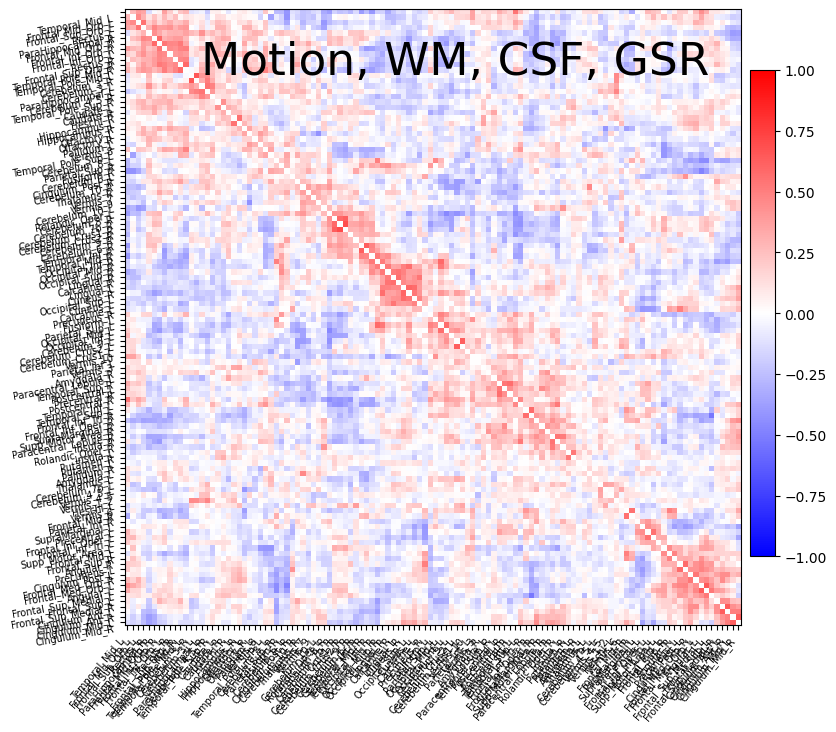

In [43]:
plotting.plot_matrix(correlation_matrix_no_gsr[4], figure=(10, 8), labels=labels,
                     vmax=1, vmin=-1,
                     title='Motion, WM, CSF, GSR',
                     reorder=True, cmap='bwr')

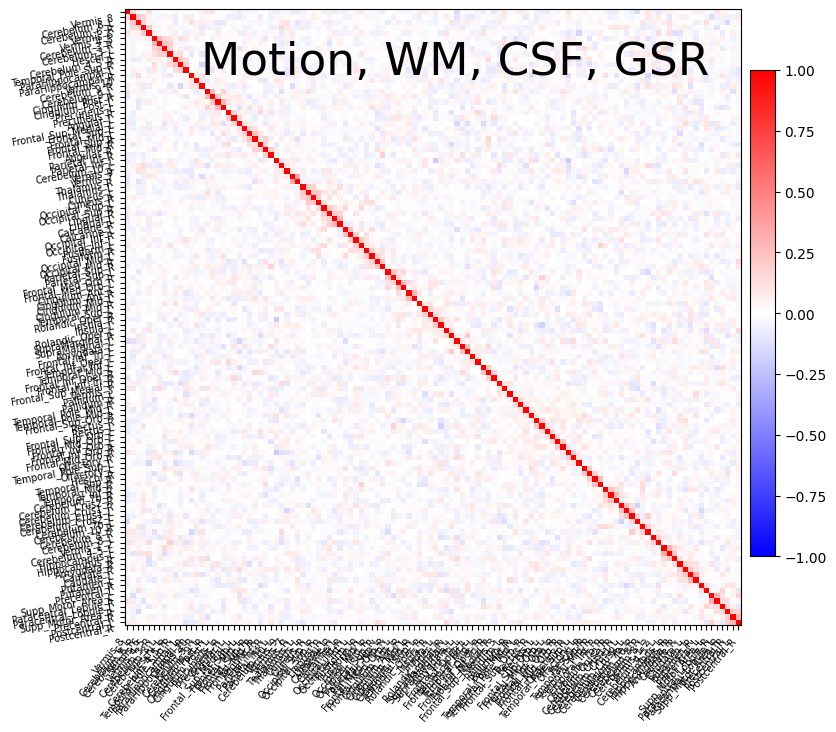

In [73]:
plotting.plot_matrix(pcorr_matrix_no_gsr[4], figure=(10, 8), labels=labels,
                     vmax=1, vmin=-1,
                     title='Motion, WM, CSF, GSR',
                     reorder=True, cmap='bwr')

In [74]:
##Get the labels for the subjects
df          = pd.read_csv('/Users/georgepulickal/Documents/ADNI_FULL/patient_info.csv')
label       = df['Research Group']
subjects    = df['Subject ID']

label_array = label.to_numpy()
subs_array  = subjects.to_numpy()

assert len(label_array) == len(correlation_matrix_no_gsr)
label_list = []
id_list = []
corr_matrices = []
pcorr_matrices = []
for i in range(len(label_array)):
    if label_array[i] == 'SMC':
        pass
    else:
        if label_array[i] == 'EMCI' or label_array[i] == 'LMCI' or label_array[i] == 'MCI':
            new_label = 1
        elif label_array[i] == 'CN':
            new_label = 0
        elif label_array[i] == 'AD':
            new_label = 2
        else:
            print('ERROR: unkown label')

        label_list.append(new_label)
        id_list.append(subs_array[i])
        corr_matrices.append(correlation_matrix_no_gsr[i])
        pcorr_matrices.append(pcorr_matrix_no_gsr[i])

assert len(label_list) == len(id_list)
assert len(id_list) == len(corr_matrices)

In [77]:
np.savetxt(labels_file, np.asarray(label_list).astype(int), delimiter=',')
for i in range(0, len(corr_matrices)):
    np.savetxt(f'{corr_matrices_dir}/corr_{id_list[i]}.csv', corr_matrices[i], delimiter=',')
    np.savetxt(f'{pcorr_matrices_dir}/pcorr_{id_list[i]}.csv', pcorr_matrices[i], delimiter=',')

In [78]:
assert len(label_list) == len(id_list)
assert len(id_list) == len(corr_matrices)

[array([[ 1.        ,  0.15959626,  0.08222417, ...,  0.0419432 ,
         0.040836  , -0.05700627],
       [ 0.15959632,  1.        ,  0.0239712 , ...,  0.05049269,
        -0.00144318, -0.05132349],
       [ 0.08222416,  0.02397121,  1.        , ..., -0.05902199,
        -0.07864223,  0.03940549],
       ...,
       [ 0.04194321,  0.05049271, -0.05902198, ...,  1.        ,
         0.15294804, -0.02492785],
       [ 0.04083599, -0.00144313, -0.07864224, ...,  0.15294808,
         1.        , -0.0545988 ],
       [-0.05700628, -0.05132358,  0.03940548, ..., -0.02492782,
        -0.05459877,  1.        ]], dtype=float32), array([[ 1.        ,  0.04187915,  0.08267996, ...,  0.07827152,
        -0.01304283,  0.0378875 ],
       [ 0.04187929,  1.        , -0.04547818, ..., -0.04500463,
        -0.06349627, -0.07926442],
       [ 0.08267998, -0.04547829,  1.        , ..., -0.06030533,
        -0.06611128, -0.07302691],
       ...,
       [ 0.07827147, -0.04500468, -0.0603054 , ...,  1.   